In [1054]:
from typing import Optional

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import math
from torch._C import dtype
from typing import Dict
from models.siren_model import Siren
from models.very_tiny_nerf_model import VeryTinyNerfModel

In [1055]:
def positional_encoding(
    tensor, num_encoding_functions=6, std_dev = 4, include_input=True, log_sampling=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.

    Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    std_dev (optional, int): Scale parameter/standard deviation, replaces the default two used in Nerf
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    # TESTED
    # Trivially, the input tensor is added to the positional encoding.

    encoding = [tensor] if include_input else []

    # Now, encode the input using a set of high-frequency functions and append the
    # resulting values to the encoding.
    frequency_bands = None
    if log_sampling:
        frequency_bands = std_dev ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    else:
        frequency_bands = torch.linspace(
            std_dev ** 0.0,
            std_dev ** (num_encoding_functions - 1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )

    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)


In [1056]:
DTYPE_BIT_SIZE: Dict[dtype, int] = {
    torch.float32: 32,
    torch.float: 32,
    torch.float64: 64,
    torch.double: 64,
    torch.float16: 16,
    torch.half: 16,
    torch.bfloat16: 16,
    torch.complex32: 32,
    torch.complex64: 64,
    torch.complex128: 128,
    torch.cdouble: 128,
    torch.uint8: 8,
    torch.int8: 8,
    torch.int16: 16,
    torch.short: 16,
    torch.int32: 32,
    torch.int: 32,
    torch.int64: 64,
    torch.long: 64,
    torch.bool: 1
}
def model_size_in_bits(model):
    """Calculate total number of bits to store `model` parameters and buffers."""
    return sum(sum(t.nelement() * DTYPE_BIT_SIZE[t.dtype] for t in tensors)
               for tensors in (model.parameters(), model.buffers()))

In [1057]:
def clamp_image(img):
    """Clamp image values to like in [0, 1] and convert to unsigned int.
    Args:
        img (torch.Tensor):
    """
    # Values may lie outside [0, 1], so clamp input
    img_ = torch.clamp(img, 0., 1.)
    # Pixel values lie in {0, ..., 255}, so round float tensor
    return torch.round(img_ * 255) / 255.

In [1058]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

In [1059]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

In [1060]:
cap = cv2.VideoCapture("../datasets/00003.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)



def get_frame(idx):
  r""" Get the RGB tensor of a specific frame in the video.
  """
  cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
  success, img = cap.read()
  if not success:
    print("Failed to load frame at index " + str(idx))
  return torch.from_numpy(np.float32(img) / 255)


In [1061]:
def xs_and_ys(width, height, frame_ind):
    r""" Construct (x, y, f) tuples.
    """

    coordinates = torch.ones([height,width]).nonzero(as_tuple=False).float()


    #Assuming the image is square is necessary for this nice vector operation
    #Change if we use non-square image
    coordinates = coordinates/ (height - 1) - 0.5

    fill_val =  frame_ind/(total_frames -1) - 0.5
    frame_indicies = torch.full((coordinates.shape[0], 1), fill_val)
    coordinates = torch.cat([coordinates, frame_indicies], -1)
 
    coordinates *= 2
    return coordinates



In [1062]:
def one_iter_npc(width, height, model, frame_ind, encoding_fn, get_minibatches_fn):

  pts = xs_and_ys(width, height, frame_ind)

  encoded_pts = encoding_fn(pts)
  
  rgb_flat = model(encoded_pts)
  rgb = torch.reshape(rgb_flat, [height, width, 3])
  return rgb

In [1063]:
def output_video(fps, width: int, height: int, encode, get_minibatches):
  r"""Build the final video from the trained model."""
  out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  def output_v(start_frame, end_frame, model):
    for f in range(start_frame, end_frame):
        rgb_predicted = clamp_image(one_iter_npc(width, height, model,
                                     f, encode,
                                     get_minibatches))

        rgb_out = cv2.normalize(src=rgb_predicted.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
                                norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        out.write(rgb_out)
    return lambda: out.release()

  return output_v

In [1064]:
def get_new_chunk():
  # model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions,
  #                           num_hidden_layers=num_hidden_layers, filter_size=filter_size)

  model = Siren(
        dim_in=3,
        dim_hidden=filter_size,
        dim_out=3,
        num_layers=num_hidden_layers,
        final_activation=torch.nn.Identity(),
        w0_initial=30.0,
        w0=30.0,
        num_encoding_functions = num_encoding_functions
    )

  l1_w = 1e-6

  print(f"Model size in bits: {model_size_in_bits(model)}")
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Lists to log metrics etc.
  psnrs = []
  iternums = []

  all_psnrs = {}


  def training_loop(start_frame, end_frame, outputter, num_iters = 500, mean_psnr_cutoff = 40):
    nonlocal model 
    nonlocal optimizer
    nonlocal psnrs
    nonlocal iternums
    nonlocal all_psnrs
    nonlocal l1_w

    chunk_frames = end_frame - start_frame
    test_frame = end_frame-1

    print("Start frame: " + str(start_frame) + ", end frame: " + str(end_frame))
    print("Total frames: " + str(chunk_frames))

  

    for i in range(num_iters + 1):
      # Randomly pick a frame as the target
      target_frame_idx = np.random.randint(start_frame, end_frame)

      target_img = get_frame(target_frame_idx)
      
      rgb_predicted = one_iter_npc(width, height, model,
                                  target_frame_idx, encode,
                                  get_minibatches)

      # Compute mean-squared error between the predicted and target images. Backprop!
      l1_reg = l1_w * torch.abs(torch.cat([p.view(-1) for p in model.parameters()])).sum()

      loss = torch.nn.functional.mse_loss(rgb_predicted, target_img) + l1_reg
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      psnr = -10. * torch.log10(loss)
      all_psnrs[target_frame_idx] = psnr.item()

      # Display images/plots/stats
      if (i > 0) and (i % display_every == 0):
        # Render the held-out view
        rgb_predicted = clamp_image(one_iter_npc(width, height, model,
                                    test_frame, encode,
                                    get_minibatches))
        print("Loss:", loss.item())
        psnrs.append(psnr.item())
        iternums.append(i)
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb_predicted.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.imshow(get_frame(test_frame))
        # plt.plot(iternums, psnrs)
        plt.title("Original")
        plt.show()

    release_out = outputter(start_frame, end_frame, model)
    return release_out, list(all_psnrs.values())

  return training_loop

In [1065]:
def chunk_processing(total_frames, outputter, seed_iters = 1000, baseline_iters = 500, iters_per_frame = 250, initial_chunk_size=2, chunk_increment=2, baseline_mean_psnr_percentage=0.9, peak_mean_psnr_percentage=0.85, min_psnr_perecentage = 0.9, train_loop = None):

    start_index = 0 

    if train_loop is None:
        train_loop = get_new_chunk()

    while start_index < total_frames:
        chunk_size = initial_chunk_size
        release_out, psnrs = train_loop(start_index, min(total_frames, start_index+chunk_size), outputter, seed_iters)
       

        mean_psnr = np.median(psnrs)
        baseline_psnr = mean_psnr
        peak_mean_psnr = mean_psnr

        min_psnr = mean_psnr
        
        
        baseline_cutoff = baseline_psnr*baseline_mean_psnr_percentage 
        print(f"Mean psnr:{mean_psnr} Baseline cutoff:{baseline_cutoff} Peak psnr:{peak_mean_psnr} Min Psnr:{min_psnr}")

        while mean_psnr >= baseline_cutoff and mean_psnr >= peak_mean_psnr_percentage*peak_mean_psnr and min_psnr > baseline_cutoff and min_psnr > min_psnr_perecentage*mean_psnr:
            chunk_size += chunk_increment
            num_iters = baseline_iters + iters_per_frame*chunk_size

            release_out, psnrs = train_loop(start_index, min(total_frames, start_index+chunk_size), outputter, num_iters)
            mean_psnr = np.median(psnrs)
            min_psnr = np.min(psnrs)

            if mean_psnr > peak_mean_psnr:
                peak_mean_psnr = mean_psnr
            print(f"Mean psnr:{mean_psnr} Baseline cutoff:{baseline_cutoff} Peak psnr:{peak_mean_psnr} Min Psnr:{min_psnr}")

        release_out, psnrs = train_loop(start_index, min(total_frames, start_index+chunk_size), outputter, num_iters)
        start_index += chunk_size
        train_loop = get_new_chunk()
        
        
    return release_out

def get_baseline_psnr(total_frames, chunk_size, seed_iters):
    train_loop = get_new_chunk()
    # target_frame_idx = np.random.randint(0, total_frames)
    target_frame_idx = 0
    release_out, psnrs = train_loop(target_frame_idx, target_frame_idx+chunk_size, outputter, seed_iters)
    return np.mean(psnrs), train_loop



Video dims: 68x68
Framerate: 30.0
Model size in bits: 2498656
Start frame: 0, end frame: 10
Total frames: 10
Loss: 0.0011241137981414795


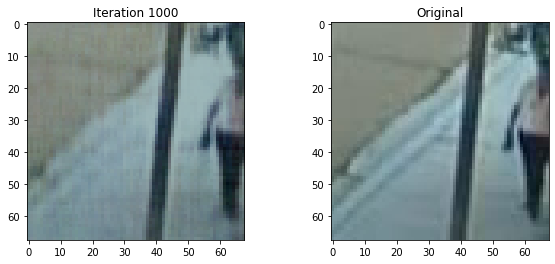

KeyboardInterrupt: 

In [1066]:
"""
Parameters for NPC training
"""

num_hidden_layers = 4
filter_size = 128
std_dev = 1.4
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 36


# Specify encoding function.
def encode(x): return positional_encoding(
    x, num_encoding_functions=num_encoding_functions, std_dev = std_dev, include_input=True, log_sampling=True)
# def encode(x): return x


# Optimizer parameters
lr = 2e-5


seed_iters = 500
baseline_iters = 250
num_iters = 10000

#Misc parameters
display_every = 1000  # Number of iters after which stats are displayed

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = 10
outputter = output_video(fps, width, height, encode, get_minibatches)

print("Video dims: " + str(width) + "x" + str(height))
print("Framerate: " + str(fps))

initial_chunk_size = 2
chunk_increment = 2


# Horrible idea, absolute standards make the algorithm only compress two frames at a time
# For most of the sections
# mean_psnr_one_fram, train_loop = get_baseline_psnr(total_frames, initial_chunk_size, seed_iters)
# print(mean_psnr_one_fram)

train_loop = get_new_chunk()
release_out,_ = train_loop(0, total_frames, outputter, num_iters)
# release_out = chunk_processing(total_frames, outputter, chunk_increment = chunk_increment , seed_iters = seed_iters, baseline_iters = baseline_iters, iters_per_frame = iters_per_frame, initial_chunk_size = initial_chunk_size, baseline_mean_psnr_percentage = 0.9)


print('Done training. Storing output...')
release_out()
print("Output complete")